In [ ]:
# PRIMARY MERGE CV CODE

import pandas as pd, os, numpy as np, random as r, pickle, math
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

class DataPretreatment:
   def __init__(
                  self, 
                  forward_current_limit=0.05, 
                  reverse_current_limit=0.01,
                  root_directory='.',
                  data_folder='Samples'
   ):
      self.forward_current_limit = forward_current_limit
      self.reverse_current_limit = reverse_current_limit
      self.root_directory = root_directory 
      self.data_folder=data_folder
      self.mechs=['EC1', 'CE', 'ECE', 'DISP', 'ECP', 'T', 'E', 'SR'] 

   def label_merge_safety(self):
      path = f'{self.root_directory}/Merge_Safety'
      if not os.path.isdir(path):
         os.mkdir(path)
      data_path = './Samples'
      for mech in self.mechs: 
         files = os.listdir(f'{self.root_directory}/{self.data_folder}/{mech}')
         files = [f for f in files if f.endswith('.txt')]
         merge_safe = {}
         conditional_safe = {}
         print(f'Treating: {mech}')
         for file in tqdm(files):
            df = pd.read_csv(f'{data_path}/{mech}/{file}')
            df = df.loc[df['v'] == min(df['v'])]
            n = len(df)//2
            fwd = df.iloc[:n, :]
            rev = df.iloc[n:, :]
            d_fwd = abs(fwd.loc[fwd.index[-100], 'A'] - fwd.loc[fwd.index[-1], 'A'])
            d_rev = abs(rev.loc[rev.index[-100], 'A'] - rev.loc[rev.index[-1], 'A'])
            left_merge = d_rev <= self.reverse_current_limit
            right_merge = d_fwd <= self.forward_current_limit
            if left_merge and right_merge:
               merge_safe[file] = (left_merge, right_merge)
            elif left_merge or right_merge:
               conditional_safe[file] = (left_merge, right_merge)
         pickle.dump(merge_safe, open(f'{path}/{mech}_safe.pkl','wb'))
         pickle.dump(conditional_safe, open(f'{path}/{mech}_half_safe.pkl','wb'))

   def gen_scan_rate_data(self):
      path = f'{self.root_directory}/Scan_Rate_Info'
      if not os.path.isdir(path):
         os.mkdir(path)
      for mech in self.mechs:
         file_path = f'{self.root_directory}/{self.data_folder}/{mech}'
         files = os.listdir(file_path)
         files = [f for f in files if f.endswith('txt')]
         data = []
         for file in files:
            df = pd.read_csv(f'{file_path}/{file}')
            srs = df['v'].unique()
            max_sr = math.log10(max(srs))
            min_sr = math.log10(min(srs))
            sr_range = max_sr-min_sr
            data.append([file, sr_range])
         res = pd.DataFrame(data, columns=["File", "Range"])
         res.to_csv(f'{path}/{mech}_SRs.csv', index=False)
      print("Done Generating Scan Rate Sheets")

class Mech:
   def __init__(self, mech, cathodic, scale_min=0.2):
      self.mech = mech
      self.cathodic = cathodic
      self.data = None
      self.file = None
      self.scaling = r.randint(100*scale_min, 100)/100
      self.bounding_box = []
      self.reversible = True

   def __str__(self):
      return f'Mech: {self.mech}, Cathodic: {self.cathodic}, Scaling: {self.scaling}, Reversible: {self.reversible}, File: {self.file}'

class MergeCV:
   def __init__(
                  self, 
                  num_to_merge=4,
                  scale_min=0.2, 
                  forward_current_limit=0.05, 
                  reverse_current_limit=0.01,
                  fractional_peak_current=0.33,
                  fractional_SR_current=0.1,
                  fractional_T_current=0.01,
                  dictating_scan_rate=-1,
                  peak_ratio=0.1,
                  additional_shift_min=0,
                  additional_shift_max=1000,
                  scan_range_tolerance=0.2,         
   ):
      self.num_to_merge = num_to_merge
      self.scale_min = scale_min
      self.forward_current_limit = forward_current_limit
      self.reverse_current_limit = reverse_current_limit
      self.fractional_peak_current = fractional_peak_current
      self.fractional_SR_current = fractional_SR_current
      self.fractional_T_current = fractional_T_current
      self.dictating_scan_rate = dictating_scan_rate
      self.peak_ratio = peak_ratio
      self.additional_shift_min = additional_shift_min
      self.additional_shift_max = additional_shift_max
      self.name = ""
      self.mechs = None
      self.res = None
      self.scan_range_tolerance = scan_range_tolerance

   def __get_mechs(self):
      mechs = [None]*self.num_to_merge
      x = r.randint(1, 8)
      if x == 1:
         cath = round(r.random())
         if cath:
            mechs[0] = Mech("T", True, self.scale_min)
         else:
            mechs[-1] = Mech("T", False, self.scale_min)

      x = r.randint(1, 8)
      if x == 2:
         cath = round(r.random())
         if cath and not mechs[0]:
            mechs[0] = Mech("ECP", True, self.scale_min)
         elif cath:
            mechs[-1] = Mech("ECP", False, self.scale_min)
         elif mechs[-1]:
            mechs[0] = Mech("ECP", True, self.scale_min)
         else:
            mechs[-1] = Mech("ECP", False, self.scale_min)

      # EC1 is equal to EC anodic or CE cathodic, EC2 is equal to CE anodic or EC cathodic
      remaining_mechs = ["E", "EC1", "ECE", "DISP", "CE", "SR"] # REMOVED SR
      for i, spot in enumerate(mechs):
         if not spot:
            x = r.randint(0, len(remaining_mechs)-1)
            cathodic = True if round(r.random()) == 1 else False
            mechs[i] = Mech(remaining_mechs[x], cathodic, self.scale_min)
      self.mechs = mechs
   
   def __get_valid_file(self, options, mechanism, host_range):
      if host_range == 0:
         return r.choice(options)
      sr_info = pd.read_csv(f'./Scan_Rate_Info/{mechanism}_SRs.csv')
      min_sr_range = host_range-self.scan_range_tolerance
      max_sr_range = host_range+self.scan_range_tolerance
      sr_info = sr_info.loc[(sr_info['Range'] >= min_sr_range) & (sr_info['Range'] <= max_sr_range)]
      sr_info = sr_info.loc[sr_info['File'].isin(options)]
      indices = sr_info.index
      return sr_info.loc[r.choice(indices), 'File']  

   def __get_files(self):
      host_range = 0
      for i, mech in enumerate(self.mechs):
         # safe means it can be merged from either side, so no special consideration is necessary
         safe = pickle.load(open(f'./Merge_Safety/{mech.mech}_safe.pkl', 'rb'))
         # half safe means it is useable as a beginning or terminal mechanism so needs to be looked at
         half_safe = pickle.load(open(f'./Merge_Safety/{mech.mech}_half_safe.pkl', 'rb'))
         if i == 1 or i == 2:
            options = list(safe.keys())
            file = self.__get_valid_file(options, mech.mech, host_range)
         # considerations on if T or ECP need to be flipped have already been made so pick any file
         elif mech.mech == 'T' or mech.mech == 'ECP':
            options = list(safe.keys())
            options.extend(list(half_safe.keys()))
            file = self.__get_valid_file(options, mech.mech, host_range)
         else:
            options = list(safe.keys())
            options.extend(list(half_safe.keys()))
            file = self.__get_valid_file(options, mech.mech, host_range)
            if file not in safe:
               # if data is only mergeable from one side, we may need to over-ride the assigned flipping
               left_safe = half_safe[file][0]
               right_safe = half_safe[file][1]
               if left_safe: # must be flipped if it is left most, otherwise can't be
                  if i == 0:
                     mech.cathodic = True
                  else:
                     mech.cathodic = False
               else: # must be flipped if it right most, otherwise can't be
                  if i == 0:
                     mech.cathodic = False
                  else:
                     mech.cathodic = True
         mech.file = file
         self.name += file[:-4] + "_"
         mech.data = pd.read_csv(f'./Samples/{mech.mech}/{file}')
         if host_range == 0:
            host_range = math.log10(max(mech.data['v'])) - math.log10(min(mech.data['v']))
         min_V = min(mech.data['V'])
         mech.data.loc[:,'V'] -= min_V
         mech.data.reset_index(inplace=True, drop=True)

   def __mirrorify(self, mech):
      scan_rates = mech.data['v'].unique()
      data = mech.data[mech.data['v'] == scan_rates[self.dictating_scan_rate]].copy()
      n = data.loc[data['V'] == max(data['V'])].index[0]
      fwd_df = data.loc[data.index <= n].copy()
      rev_df = data.loc[data.index > n].copy()
      pots = pd.Series(list(set(fwd_df['V']).intersection(set(rev_df['V']))))
      mech.data = mech.data.loc[mech.data['V'].isin(pots)]

   def __adjust_data(self, mech):
      flip = -1 if mech.cathodic else 1
      mech.data.loc[:, 'A'] *= mech.scaling*flip
      res = pd.DataFrame()
      if mech.cathodic:
         for v in mech.data['v'].unique():
            t = mech.data.loc[mech.data['v'] == v].copy()
            og_pots = list(t['V'])
            n = t.index[len(t)//2]
            fwd = t.loc[t.index < n]
            rev = t.loc[t.index >= n]
            rev = pd.concat([rev, fwd])
            rev.loc[:, 'V'] = og_pots
            # currents = t.loc[:,'A']
            # n = len(currents)//2
            # fwd_currents = list(currents[:n])
            # rev_currents = list(currents[n:])
            # rev_currents.extend(fwd_currents)
            # t['A'] = rev_currents
            res = pd.concat([res, rev])
         mech.data = res
      mech.data.reset_index(inplace=True, drop=True) 

   def __get_reversibility(self, mech):
      if mech.mech == 'T':
         return False
      lcl_data = mech.data.loc[mech.data['v'] == max(mech.data['v'])].copy()
      min_cur = min(lcl_data['A'])
      max_cur = max(lcl_data['A'])
      peak_ratio = abs(min_cur/max_cur) if abs(min_cur) < max_cur else abs(max_cur/min_cur)
      last_cur = lcl_data.loc[lcl_data.index[-1], 'A']
      if abs(last_cur-min_cur) < 0.02:
         return False
      return peak_ratio >= 0.1
   
   def __find_index(self, l, r, target, data):
      decreasing = data.loc[l, 'A'] > data.loc[r, 'A']
      while (l <= r):
         m = l+(r-l) // 2
         if data.loc[m, 'A'] < target:
            if decreasing:
               r = m-1
            else:
               l = m+1
         else:
            if decreasing:
               l = m+1
            else:
               r = m-1
      return l if l <= data.index[-1] else data.index[-1]

   def __handle_tafel(self, mech, data):
      indices = data.index
      min_cur = data.loc[indices[0], 'A']
      max_cur = max(data['A'])
      target = self.fractional_T_current*(max_cur-min_cur)+min_cur 
      n = len(indices)//2
      index = self.__find_index(indices[0], indices[n-1], target, data)
      mech.data['merge_point'] = False
      mech.data.loc[index, 'merge_point'] = True
      mech.data.loc[indices[n], 'merge_point'] = True
  
   def __calculate_merge_reps(self, mech):
      scan_rates = mech.data['v'].unique()
      rep_data = mech.data[mech.data['v'] == scan_rates[self.dictating_scan_rate]].copy()

      if mech.mech == 'T':
         self.__handle_tafel(mech, rep_data)
         return

      max_A = max(rep_data['A'])
      min_A = min(rep_data['A'])
      
      main_peak = max_A if max_A > abs(min_A) else min_A
      # Mpi = max peak index, mpi = min peak index
      Mpi = rep_data[rep_data['A'] == max_A].index[0]
      mpi = rep_data[rep_data['A'] == min_A].index[0]

      merge_points = []
      indices = rep_data.index
      l = indices[0]
      r = indices[-1]
      n = indices[len(indices)//2]
      frac = self.fractional_peak_current
      if mech.mech == 'SR':
         frac = self.fractional_SR_current
      if rep_data.loc[Mpi, 'A'] == main_peak or mech.reversible:
         target = frac*(max_A-rep_data.loc[n,'A']) + rep_data.loc[n,'A']
         merge_points.append(self.__find_index(l, Mpi, target, rep_data))
         merge_points.append(self.__find_index(Mpi, n, target, rep_data))
         
      if rep_data.loc[mpi, 'A'] == main_peak or mech.reversible:
         target = rep_data.loc[r,'A'] - frac*(abs(min_A-rep_data.loc[r,'A']))
         merge_points.append(self.__find_index(n,mpi, target, rep_data))
         merge_points.append(self.__find_index(mpi, r, target, rep_data))
   
      mech.data['merge_point'] = False
      for point in merge_points:
         mech.data.loc[point, 'merge_point'] = True

   def initialize_data(self):
      self.__get_mechs()
      self.__get_files()
      for mech in self.mechs:
         self.__mirrorify(mech)
         mech.reversible = self.__get_reversibility(mech)
         self.__calculate_merge_reps(mech)
         self.__adjust_data(mech)

   def run_spoof(self, files, orientations, scales):
      for i, mech in enumerate(self.mechs):
         file = files[i]
         scale = scales[i]
         orientation = orientations[i]
         mech.mech = file[:file.find("_")]
         mech.file = file
         mech.scaling = scale
         mech.direction = orientation
         mech.data = pd.read_csv(f'./Samples/{mech.mech}/{file}.txt')
         mech.reversible = self.__get_reversibility(mech)
         self.__adjust_data(mech)
         self.__calculate_merge_reps(mech)
         
   def __calculate_shifts(self):
      def get_mps(indices, data):
         max_potential = data.loc[indices[0], 'V']
         min_potential = max_potential
         for i in range(1, len(indices)):
            cur = data.loc[indices[i], 'V']
            max_potential = max(max_potential, cur)
            min_potential = min(min_potential, cur)
         return [min_potential, max_potential]

      host = self.mechs[0].data
      mpis = host.loc[host['merge_point']].index
      host_mps = get_mps(mpis, host)
      shifts = [0]
      for i in range(1, len(self.mechs)):
         guest = self.mechs[i].data
         mpis = guest.loc[guest['merge_point']].index
         guest_mps = get_mps(mpis, guest)
         host_pot = host_mps[1]
         guest_pot = guest_mps[0]
         rand_shift = r.randint(self.additional_shift_min, self.additional_shift_max)
         shift = (host_pot-guest_pot) + rand_shift
         shifts.append(shift)
         guest_mps[1] += shift
         host_mps = guest_mps
      return shifts

   def __calculate_bounding(self,mech):
      min_mp = float('inf')
      max_mp = float('-inf')
      if  mech.reversible or mech.mech == 'T':
         for mp in mech.data.loc[mech.data['merge_point']].index:
            min_mp = min(min_mp, mech.data.loc[mp, 'V'])
            max_mp = max(max_mp, mech.data.loc[mp, 'V'])
      elif mech.cathodic:
         for mp in mech.data.loc[mech.data['merge_point']].index:
            min_mp = min(min_mp, mech.data.loc[mp, 'V'])
         peak_pot_ind = mech.data.loc[mech.data['A'] == min(mech.data['A'])].index[0]
         peak_pot = mech.data.loc[peak_pot_ind, 'V']
         diff = abs(peak_pot-min_mp)
         max_mp = peak_pot + diff
      else:
         for mp in mech.data.loc[mech.data['merge_point']].index:
            max_mp = max(max_mp, mech.data.loc[mp, 'V'])
         peak_pot_ind = mech.data.loc[mech.data['A'] == max(mech.data['A'])].index[0]
         peak_pot = mech.data.loc[peak_pot_ind, 'V']
         diff = abs(peak_pot-max_mp)
         min_mp = peak_pot - diff
      mech.bounding_box.extend([min_mp, max_mp])

   def format_data(self):
      shifts = self.__calculate_shifts()
      for i, mech in enumerate(self.mechs):
         mech.data.loc[:,'V'] += shifts[i]
         mapping = {v:i for i,v in enumerate(mech.data['v'].unique())}
         mech.data.replace({'v': mapping}, inplace=True)
         self.__calculate_bounding(mech)
         mech.data.drop(['merge_point'], axis=1, inplace=True)

   def __merge_dfs(self, dfs, sr, rev=False):
      res = pd.DataFrame()
      left_adds = []
      right_adds = []
      max_V = max(dfs[-1]['V'])
      min_V = min(dfs[0]['V'])
      res = pd.DataFrame(columns=['V','A','v'])
      res['V'] = range(int(min_V), int(max_V))
      res['v'] = sr
      for df in dfs:
         if rev:
            df = df[::-1]
            df.reset_index(inplace=True, drop=True)
         left_adds.append([min(df['V']), df.loc[df.index[0], 'A']])
         right_adds.append([max(df['V']), df.loc[df.index[-1], 'A']])   
         res = pd.concat([res, df]).groupby(['V','v']).sum().reset_index()
      for left in left_adds:
         res.loc[res['V'] < left[0], 'A'] += left[1]
      for right in right_adds:
         res.loc[res['V'] > right[0], 'A'] += right[1]
      return res

   def merge(self, single=False):
      res = pd.DataFrame()

      for i in range(6):
         fwd_dfs = []
         rev_dfs = []
         name = ""
         global_max = 0
         for j, mech in enumerate(self.mechs):
            if j == self.num_to_merge-1:
               global_max = max(mech.data['V'])
            name += mech.file[:-4]
            data = mech.data[mech.data['v'] == i].copy()
            data.reset_index(inplace=True, drop=True)
            indices = data.index
            n = indices[len(indices)//2]
            fwd_df = data.iloc[:n, :].copy()
            rev_df = data.iloc[n:, :].copy()
            fwd_dfs.append(fwd_df)
            rev_dfs.append(rev_df)

         fwd_full = self.__merge_dfs(fwd_dfs, i)
         rev_full = self.__merge_dfs(rev_dfs, i, rev=True)
         rev_full = rev_full[::-1]
         res = pd.concat([res, fwd_full, rev_full])
         if single:
            res = res.loc[(res['V'] > 0) & (res['V'] < global_max)]
            res.reset_index(inplace=True, drop=True)
            self.res = res
            return res # tabbed in for single scan rate
      res = res.loc[(res['V'] > 0) & (res['V'] < global_max)]
      res.reset_index(inplace=True, drop=True)
      self.res = res
      return res

   def simple_plot(self):
      for mech in self.mechs:
         data = mech.data
         plt.scatter(data['V'], data['A'], s=0.1, c=data['v'], cmap='Set2')
         plt.show()
         plt.clf()

   def fancy_plot(self, save=False, highlight=False, img_type='png'):
      fig = plt.figure(constrained_layout=True)
      gs = GridSpec(4,2, figure=fig,hspace=0, wspace=0)
      cmap='viridis'
      components = []
      components.append(fig.add_subplot(gs[3:4, :1]))
      components.append(fig.add_subplot(gs[2:3, :1]))
      components.append(fig.add_subplot(gs[3:4, -1:]))
      components.append(fig.add_subplot(gs[2:3, -1:]))

      ax1 = fig.add_subplot(gs[:2,:])
      infos = [["Mech"],["Scaling"],["Direction"],["Reversible"]]
      name = ""
      if highlight:
         colors=['rebeccapurple', 'dodgerblue', 'cyan', 'black']
      else:
         colors=['white']*self.num_to_merge
      bar_xs = []
      bar_widths = []
      bounding_boxes = []
      bb_colors = ['grey', 'black', 'grey', 'black']
      for i, mech in enumerate(self.mechs):
         name += mech.file[:-4] + "_"
         infos[0].append(mech.mech)
         infos[1].append(mech.scaling)
         infos[2].append("cathodic" if mech.cathodic else "anodic")
         infos[3].append(mech.reversible)
         ax = components.pop(0)
         ax.get_xaxis().set_ticks([])
         ax.get_yaxis().set_ticks([])
         ax.patch.set_facecolor(colors[i])
         ax.patch.set_alpha(0.2)
         ax.scatter(mech.data['V'], mech.data['A'], s=0.02, c=mech.data['v'], cmap=cmap, zorder=1)
         min_V = max(0, min(mech.data['V']))
         max_V = min(max(self.res['V']), max(mech.data['V']))
         bar_width = max_V-min_V
         bar_xs.append(min_V + bar_width//2)
         bar_widths.append(max_V-min_V)
         y_range = max(mech.data['A']) - min(mech.data['A'])
         x_range = max(mech.data['V']) - min(mech.data['V'])
         n = len(mech.bounding_box)
         bounding_boxes.append(mech.bounding_box)
         widths = [0.02*x_range]*n
         ax.bar(mech.bounding_box, [y_range]*n, bottom=[min(mech.data['A'])]*n, width=widths, zorder=0, color=bb_colors[i])


      bottom = min(self.res['A'])
      y_range = max(self.res['A']) - min(self.res['A'])
      x_range = max(self.res['V']) - min(self.res['V'])
      bar_heights = [y_range/4]*self.num_to_merge
      bottoms = [bottom + i*bar_heights[0] for i in range(4)]
      bar_heights = [y_range/4]*self.num_to_merge
      ax1.bar(bar_xs, bar_heights, bottom=bottoms, width=bar_widths, color=colors, alpha=0.2, zorder=0)
      ax1.scatter(self.res['V'], self.res['A'], s=0.05, c=self.res['v'], cmap=cmap, zorder=len(bounding_boxes)+1)
      for i, bb in enumerate(bounding_boxes):
         ax1.bar(bb, y_range, width=0.005*x_range, bottom=min(self.res['A']), color=bb_colors[i], zorder=i+1)
      ax1.table(infos, loc='top', cellLoc='center')
      ax1.tick_params(axis="both", labelsize=8)
      if save:
         plt.savefig(f'./Graphs/{name}image.{img_type}', dpi=200)
      else:
         plt.show()
      plt.clf()
      plt.close('all')

   def save(self):
      info = {}
      for i, mech in enumerate(self.mechs):
         info['Cathodic'] = mech.cathodic
         info['Scaling'] = mech.scaling
         info['File'] = mech.file
         info['Position'] = i
      pickle.dump(info, open(f'./Generated_Data/{self.name}details', 'wb'))
      pickle.dump(self.res, open(f'./Generated_Data/{self.name}data', 'wb'))

   def get_report(self, file):
      mech = file[:file.find('_')]
      mech_obj = Mech(mech, False)
      mech_obj.file = file
      mech_obj.data = pd.read_csv(f'./Samples/{mech}/{file}')
      mech_obj.data.loc[:, 'A'] *= mech_obj.scaling
      self.mechs = [mech_obj]
      self.__calculate_merge_reps(mech_obj)
      reversible = self.__get_reversibility(mech_obj)
      merge_points = mech_obj.data.loc[mech_obj.data['merge_point']].index
      pots = sorted([mech_obj.data.loc[i, 'V'] for i in merge_points])
      print(mech_obj)
      print(f'Reversible: {reversible}, Merge Potentials: {pots}')
      self.simple_plot()

for i in tqdm(range(100)): # ~ 100/minute w/ graphing every 25, ≥ 140k per day)
   try:
      merger = MergeCV(scan_range_tolerance=1, fractional_peak_current=0.25)
      merger.initialize_data()
      #merger.run_spoof(['CE_1992', 'ECE_3147', 'DISP_4193', 'ECE_12836'], [True, True, False, True], [0.84, 0.23, 0.66, 0.24])
      merger.format_data()
      merger.merge()
      if i % 1 == 0:
         merger.fancy_plot(save=True, highlight=True, img_type='jpeg')
      #merger.save()
   except:
     print("oopsie")
m = MergeCV()
m.get_report('T_426.txt')


In [ ]:
# SCRIPT FOR FIXING SR CASES

import pandas as pd, os 

path = './Samples/SR'
files = os.listdir(path)
files = [f for f in files if f.endswith('txt')]

def fill_scan(df, sr):
   if df.loc[df.index[0], 'V'] > df.loc[df.index[-1],'V']:
      df = df[::-1]
   sr = df['v'].unique()[0]
   min_V = int(min(df['V']))
   max_V = int(max(df['V']))
   og_pots = df['V'].unique()
   new_pots = range(min_V, max_V)
   res = pd.DataFrame()
   res['V'] = new_pots
   res['v'] = sr
   res = pd.concat([res, df]).groupby(['V','v']).sum().reset_index()
   res.loc[~res['V'].isin(og_pots), 'A'] = None
   res.interpolate(columns=['A'], inplace=True)
   return res

for i, file in enumerate(files):
   f = pd.read_csv(f'{path}/{file}')
   #f.loc[:,'V'] *= (1.5 + 1*r.random())
   f.loc[:, 'V'] = round(f.loc[:,'V'])
   res = pd.DataFrame()
   for v in f['v'].unique():
      t = f.loc[f['v'] == v].copy()
      ind = t.loc[t['V'] == max(t['V'])].index
      fwd = t.loc[:ind[1]]
      fwd = fill_scan(fwd, v)
      rev = t.loc[ind[1]:]
      rev = fill_scan(rev, v)
      rev = rev[::-1]
      interped = pd.concat([fwd, rev])
      res = pd.concat([res, interped])
   res.to_csv(f'{path}/{file}', index=False)
   
res

./Samples/ECP/ECP_5843


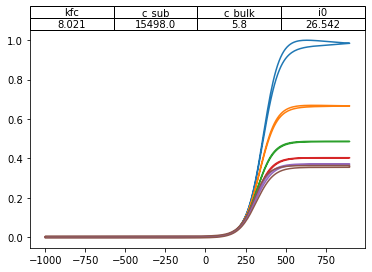

In [1]:
#SCRIPT FOR MANUAL FILE REMOVAL

import pandas as pd, os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle
import shutil

mech = 'ECP'
path = f'./Samples/{mech}'
del_path = f'./Deleted_Case_DBs/{mech}'
trash_path = f'./TRASH/{mech}'
files = os.listdir(path)
files = [f for f in files if f.endswith('txt')]
to_del = []

def plot_me(f, meta_file, path):
   for v in f['v'].unique():
      t = f.loc[f['v'] == v].copy()
      plt.plot(t['V'], t['A'])
   
   print(f'{path}/{meta_file}')
   meta_data = pd.read_csv(f'{path}/{meta_file}')
   labels = ['kfc', 'c_sub', 'c_bulk','i0']
   vals = [round(meta_data.loc[0,label],3) for label in labels]
   info = [labels, vals]
   plt.table(info, loc='top', cellLoc='center')
   plt.show()
   plt.clf()
   mark = input("Delete: ")
   clear_output()
   return mark

def delete(data_path, del_path, trash_path):
   for file in os.listdir(del_path):
      to_del = pickle.load(open(f'{del_path}/{file}', 'rb'))
      for case in to_del:
         shutil.move(f'{data_path}/{case}', f'{trash_path}/{case}')
         shutil.move(f'{data_path}/{case[:-4]}', f'{trash_path}/{case[:-4]}')

i = 0
while i < len(files):
   file = files[i]
   f = pd.read_csv(f'{path}/{file}')
   mark = plot_me(f, file[:-4], path)
   if mark == 'x':
      i -= 2
   elif mark == 'y':
      to_del.append(file)
   if i % 100 == 0 or i == len(files)-1:
      pickle.dump(to_del, open(f'{del_path}/{mech}_{i}', 'wb'))
      to_del = []
   i += 1

print(to_del)
delete(path, del_path, trash_path)